# Housing Prices Prediction

This is my notebook on housing prices prediction, using the Ames, Iowa dataset hosted on Kaggle. It's a great way to apply regression techniques and learn how to deal with feature selection and engineering, since the number of features in this dataset is rather large.

I'm going to take a very structured approach to this data science problem. It's a very rich dataset that throws up a lot of questions about how to deal with it appropriately.

Going through the typical data science/machine learning workflow, we'll do the following:

- **Exploratory data analysis**: First, we need to understand what we are working with. EDA gives us an initial look at the data and its characteristics before diving into modelling. A few points that popped into my head right away when inspecting the dataset:
    - How to go about the EDA in a dataset with so many features? Should we ignore certain features in the beginning, and come back to them later?
    - Start with correlation between the sale price and other features? Pick only the most correlated ones?
- **Data Processing**: As always, the raw dataset is not quite ready to be used in a machine learning model, so we'll have to go through it, encode categorical features and fill in missing values. Regarding data processing, I had the following questions in mind right from the beginning:
    - How to go about processing all these different features? There are both numeric and categorical features, with some categorical features that are definitely ordinal, while others aren't. 
- **Feature Engineering**: With the large number of features in this dataset, the possibilities for further feature engineering are extensive.
    - There are so many possibilities for feature engineering, it will take some time to figure out which ones are useful and which ones aren't. This is also dependent of the model selection process, since e.g. for linear regression the features have to be engineered, while a feed-forward neural net would be able to figure out important interactions by itself.
- **Model Selection and Cross Validation**: This is the fun part, where we will build various models, tune their hyperparameters, and select the best performing model to make predictions
    - The competition uses an evaluation based on the RMSE between the log of predicted and actual price. I haven't worked with this metric before and at this point I'm not sure how to use it directly in sklearn workflows.
    - Which models should we train? It would be fun to explore a bunch of different regression models, my top picks being different tree-based models (RFs, boosted trees), linear regression, neural nets, and support vector regressors
    - We need to be careful to avoid overfitting this dataset.
- **Making Predictions**: Finally, we can make predictions to submit in the housing prices competition on Kaggle.

Let's get started!

# Exploratory Data Analysis

In [1]:
# load libraries
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib
import matplotlib.pyplot as plt
# inline magic
%matplotlib inline
import seaborn as sns; sns.set()

training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

training_data.head(n=10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [2]:
training_data.shape

(1460, 81)

There are a lot of features in this dataset: 81. It might be easiest to just pick out the ones that seem most important in the beginning, and ignore the rest until a later stage. Some features can be grouped as they are relevant only to a specific part of the house.

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
training_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


It seems that there are very few - if any - **true** missing values. Based on the description of the features in the metadata file, NA mostly indicates that the house does not have the relevant feature, rather missing in the data collection.

Start by exploring some of the features in groups, and focus on visual EDA for now:

**General**

- MSSubClass
- MSZoning
- LotArea
- LotFrontage
- Street
- Alley
- LotShape
- LandContour
- LotConfig
- LandSlope
- Neighborhood
- Condition1
- Condition2
- BldgType
- HouseStyle
- OverallQual
- OverallCond
- YearBuilt
- YearRemodAdd
- Foundation
- Functional
- YrSold
- SalePrice
- SaleType
- SaleCondition

**Rooms**

- FullBath
- HalfBath
- BedroomAbvGr
- KitchenAbvGr
- KitchenQual
- TotRmsAbvGrd

**Basement**

- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinSF1
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF

**Garage**

- GarageType
- GarageYrBlt
- GarageFinish
- GarageCars
- GarageArea
- GarageQual
- GarageCond

**Exterior and Roof**

- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- MasVnrArea
- ExterQual
- ExterCond

**Luxury features**

- Fireplaces
- FireplaceQu

**Porch/Patio/Pool**

- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- PoolQC
- Fence
- MiscFeature
- MiscVal

**Utilities**

- Utilities
- Heating
- HeatingQC
- CentralAir
- Electrical

# General features

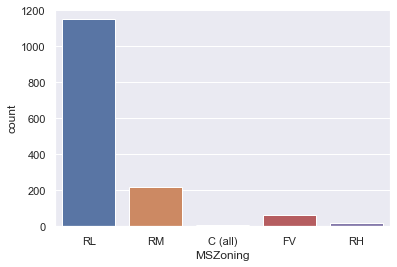

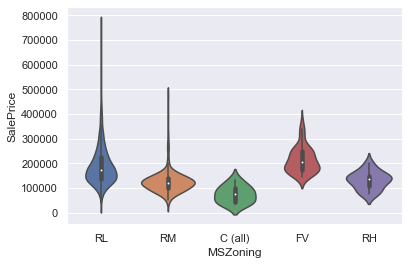

In [5]:
sns.countplot(data=training_data, x='MSZoning'); plt.show()
sns.violinplot(data=training_data, x='MSZoning', y='SalePrice');

- Large majority of buildings are in residential areas of low or medium density. Categories C, FV, RH are underrepresented. There seem to be clear differences in price between the different types of areas.

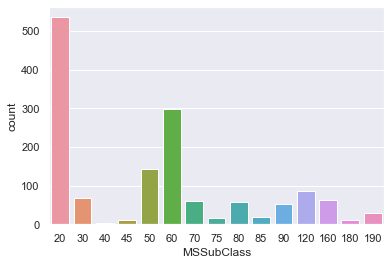

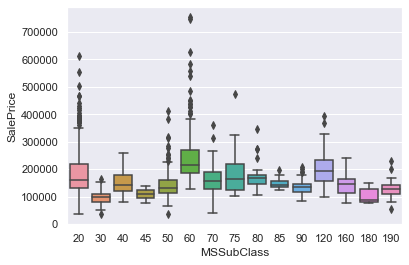

In [6]:
sns.countplot(data=training_data, x='MSSubClass'); plt.show()
sns.boxplot(data=training_data, x='MSSubClass', y='SalePrice');

- Not sure how useful this MSSubClass classification is. Based on description, most of it can be inferred from combination of number of levels/stories and building year. Most houses fall into categories 20, 50, 60. Replace MSSubClass with average price of house in that category?

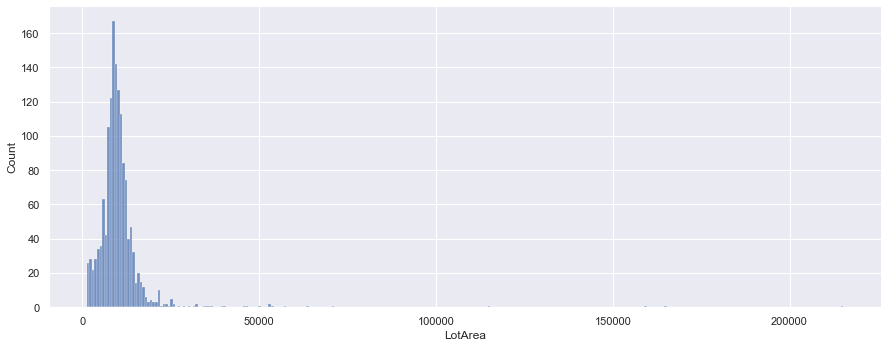

In [7]:
sns.displot(data=training_data, x='LotArea', kde=False, aspect=2.5);

In [8]:
print(training_data['LotArea'].describe())

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


- Lot area is interesting: Most are below 25000 sqft, and the minimum is 1300sqft. There are a few outliers with massive lot area. The kde of this feature would be close to normal but is cut off at zero of course.

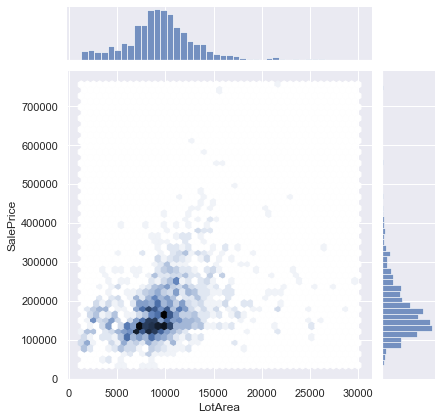

In [9]:
sns.jointplot(data=training_data[training_data['LotArea'] < 30000.0], x='LotArea', y='SalePrice', kind='hex');

- There seems to be some correlation between the lot area and sale price. I've cut off the lot area at 30000 to make the plot more meaningful.

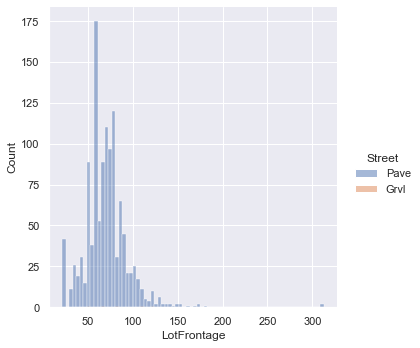

In [10]:
sns.displot(data=training_data, x='LotFrontage', hue='Street');

- Lot frontage is defined as length of street connected to property. It has a number of missing values: how to interpret these? Are those properties not connected to a street? This can't be the case, as the 'Street' feature has no missing values, so there must always be some type of access and therefore lot frontage.
- It might make sense to simply replace these with the median.

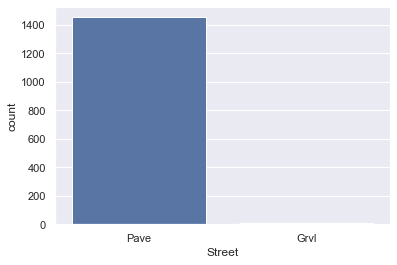

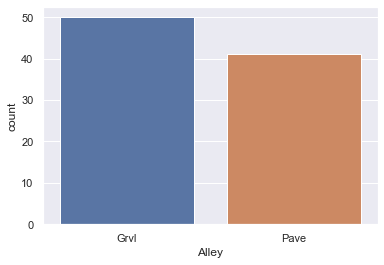

In [11]:
sns.countplot(data=training_data, x='Street'); plt.show()
sns.countplot(data=training_data, x='Alley');

- Both of these features could probably be ignored.

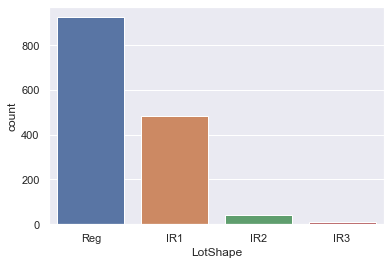

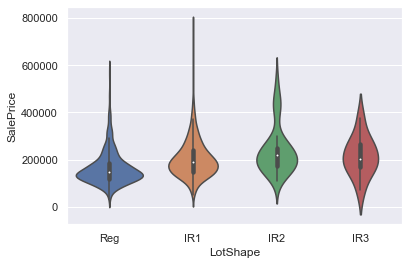

In [12]:
sns.countplot(data=training_data, x='LotShape'); plt.show()
sns.violinplot(data=training_data, x='LotShape', y='SalePrice');

- Most lots are shaped regularly, no clear connection between shape and price: could be that there is a different factor that is important. Hints that more irregular lots might be more expensive (maybe larger?)

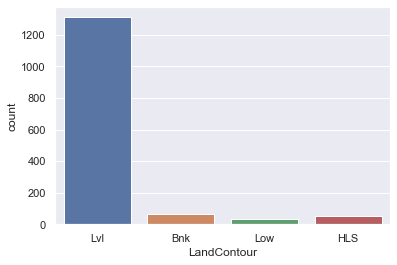

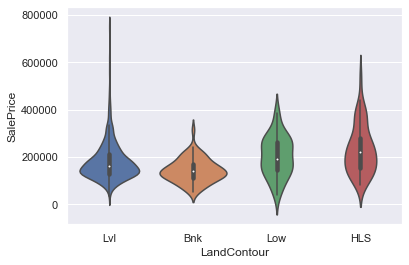

In [13]:
sns.countplot(data=training_data, x='LandContour'); plt.show()
sns.violinplot(data=training_data, x='LandContour', y='SalePrice');

- Most land is level. Prices are rather spread, no clear relation to LandContour.

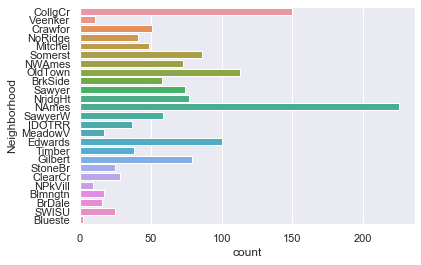

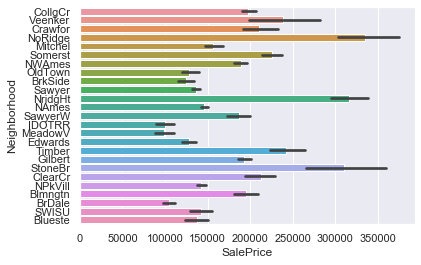

In [14]:
sns.countplot(data=training_data, y='Neighborhood'); plt.show()
sns.barplot(data=training_data, y='Neighborhood', x='SalePrice');

- Not sure what to make of this yet - might be useful to group neighborhoods according to average house prices, or drop this feature altogether?

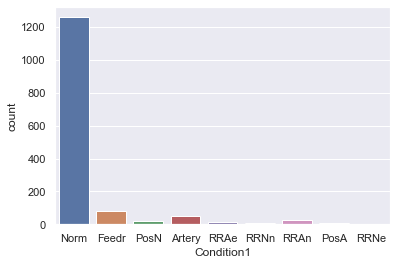

In [15]:
sns.countplot(data=training_data, x='Condition1');

- Most houses fall into one class. Might be best to ignore this feature.

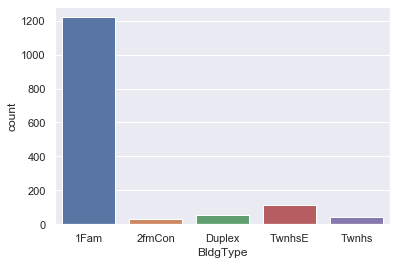

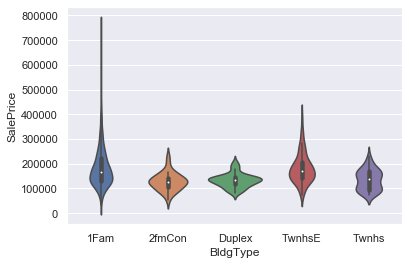

In [16]:
sns.countplot(data=training_data, x='BldgType'); plt.show()
sns.violinplot(data=training_data, x='BldgType', y='SalePrice');

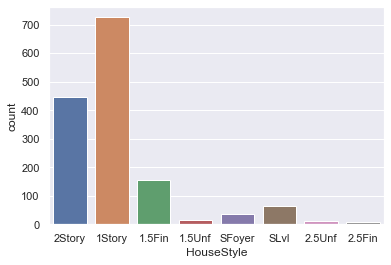

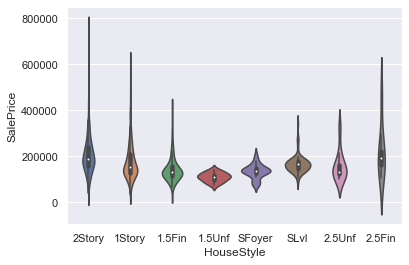

In [17]:
sns.countplot(data=training_data, x='HouseStyle'); plt.show()
sns.violinplot(data=training_data, x='HouseStyle', y='SalePrice');

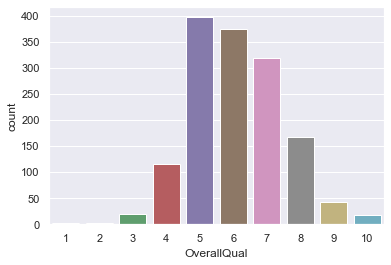

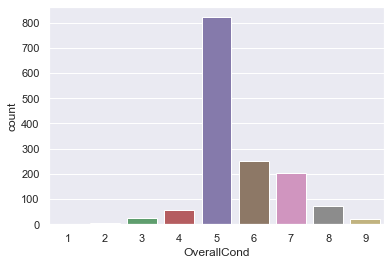

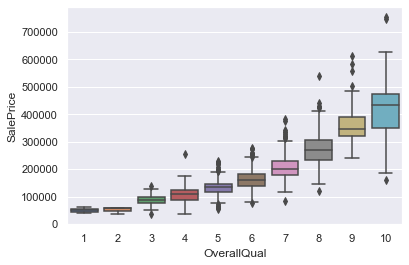

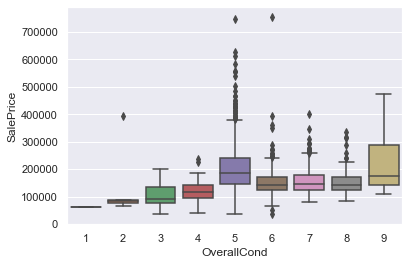

In [18]:
sns.countplot(data=training_data, x='OverallQual'); plt.show()
sns.countplot(data=training_data, x='OverallCond'); plt.show()
sns.boxplot(data=training_data, x='OverallQual', y='SalePrice'); plt.show()
sns.boxplot(data=training_data, x='OverallCond', y='SalePrice');

- Most houses are average, which is to be expected.
- OverallQual is nicely correlated with sale price. OverallCond only up to roughly average quality, beyond that is doesn't matter.

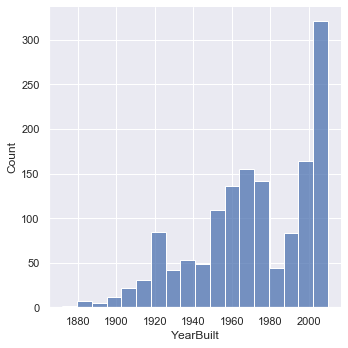

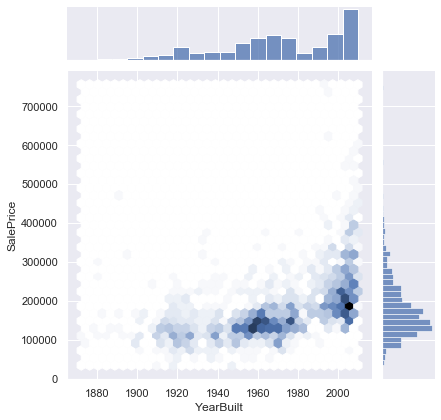

In [19]:
sns.displot(data=training_data, x='YearBuilt'); plt.show()
sns.jointplot(data=training_data, x='YearBuilt', y='SalePrice', kind='hex');

- This distribution looks reasonable. There might be a slight correlation between the two variables. Would be useful to turn this into 'age of house' feature.

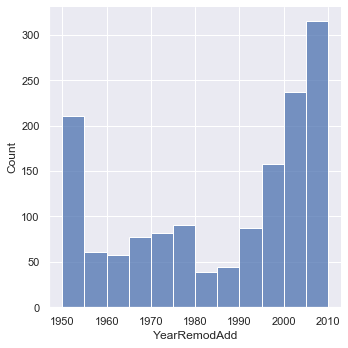

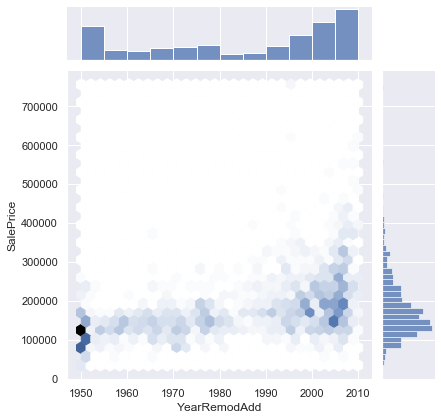

In [20]:
sns.displot(data=training_data, x='YearRemodAdd'); plt.show()
sns.jointplot(data=training_data, x='YearRemodAdd', y='SalePrice', kind='hex');

- Turn this feature into binary 'Remodelled? yes/no' feature. 

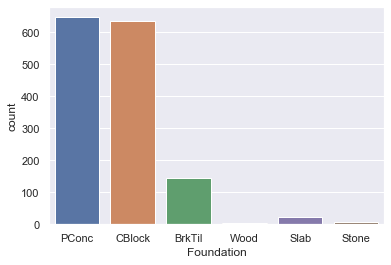

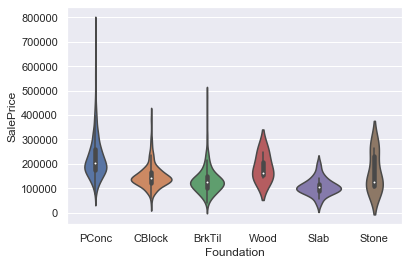

In [21]:
sns.countplot(data=training_data, x='Foundation'); plt.show()
sns.violinplot(data=training_data, x='Foundation', y='SalePrice');

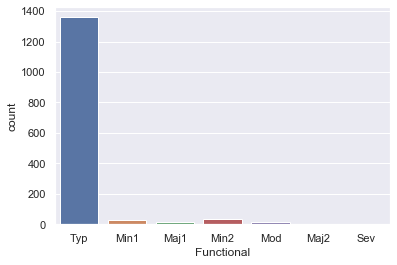

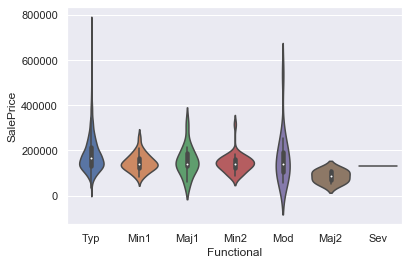

In [22]:
sns.countplot(data=training_data, x='Functional'); plt.show()
sns.violinplot(data=training_data, x='Functional', y='SalePrice');

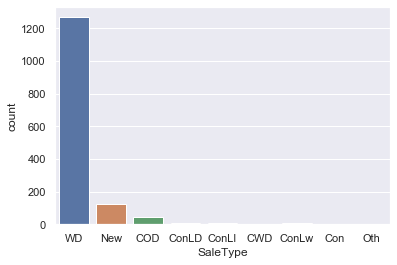

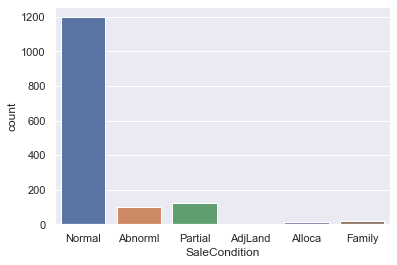

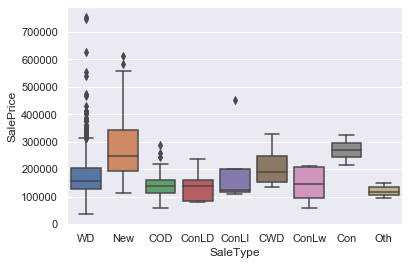

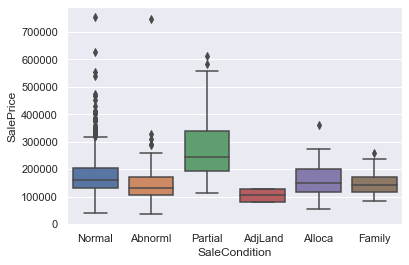

In [23]:
sns.countplot(data=training_data, x='SaleType'); plt.show()
sns.countplot(data=training_data, x='SaleCondition'); plt.show()
sns.boxplot(data=training_data, x='SaleType', y='SalePrice'); plt.show()
sns.boxplot(data=training_data, x='SaleCondition', y='SalePrice'); plt.show()

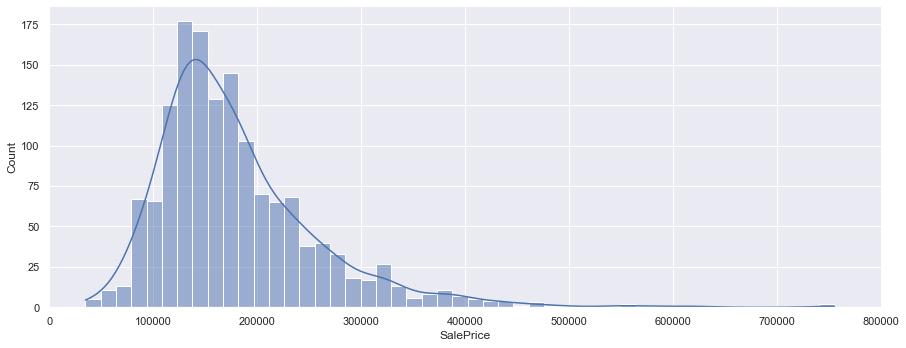

In [24]:
sns.displot(data=training_data, x='SalePrice', kde=True, aspect=2.5);
plt.xlim([0,800000]);

- Distribution of the sale price seems reasonable, but has a heavy tail at larger values.

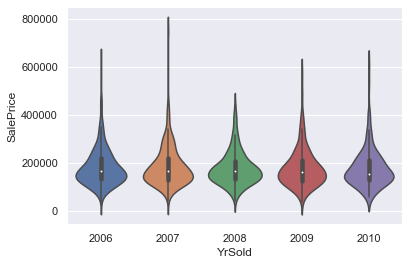

In [25]:
sns.violinplot(data=training_data, x='YrSold', y='SalePrice');

- I can't see a pattern here.

**Some of the general features are already very predictive.**

## Rooms

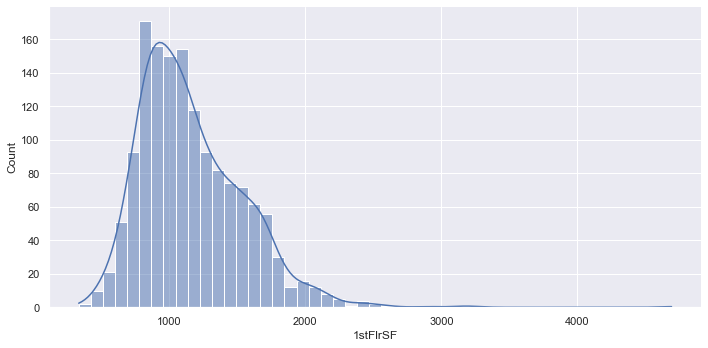

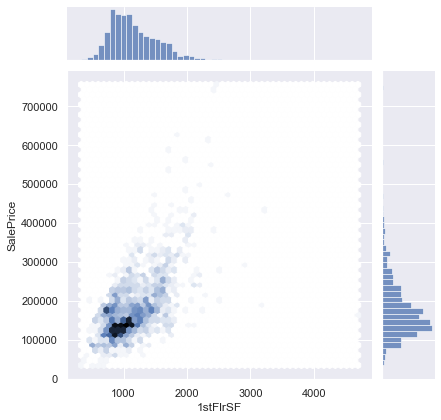

In [26]:
sns.displot(data=training_data, x='1stFlrSF', kde=True, aspect=2); plt.show()
sns.jointplot(data=training_data, x='1stFlrSF', y='SalePrice', kind='hex');

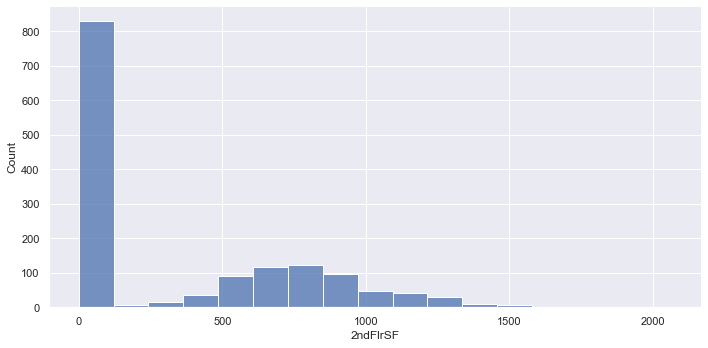

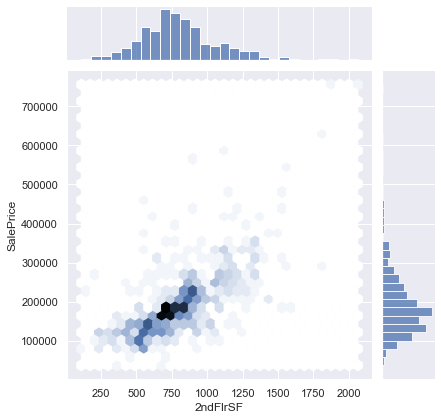

In [27]:
sns.displot(data=training_data, x='2ndFlrSF', aspect=2); plt.show()
sns.jointplot(data=training_data[training_data['2ndFlrSF'] > 0], x='2ndFlrSF', y='SalePrice', kind='hex');

- These distributions also make sense - zero 2nd floor sf means there is no 2nd floor. Might be useful to introduce an indicator variable 0/1 for presence of 2nd floor?
- Reasonable degree of correlation between size of floors and price.

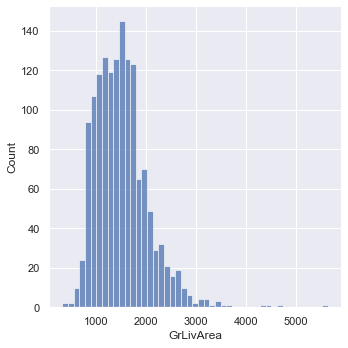

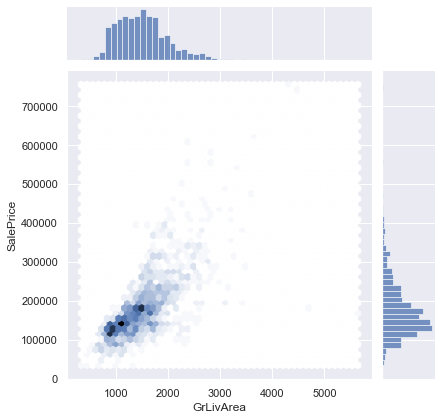

In [28]:
sns.displot(data=training_data, x='GrLivArea'); plt.show()
sns.jointplot(data=training_data, x='GrLivArea', y='SalePrice', kind='hex');

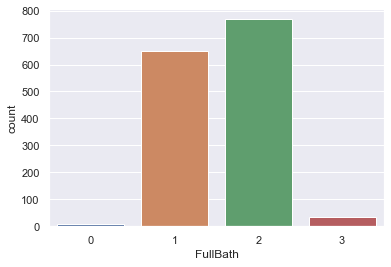

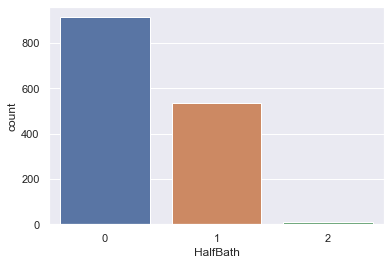

In [29]:
sns.countplot(data=training_data, x='FullBath'); plt.show()
sns.countplot(data=training_data, x='HalfBath');

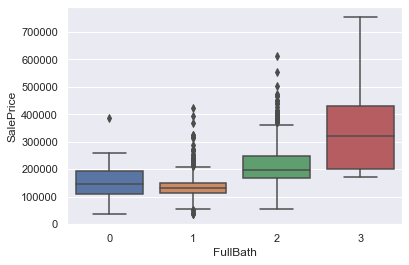

In [30]:
sns.boxplot(data=training_data, x='FullBath', y='SalePrice'); plt.show()

- Bigger house, more bathrooms means higher sale price. Makes sense.

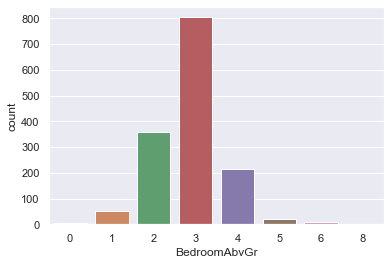

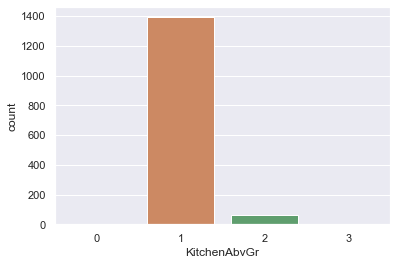

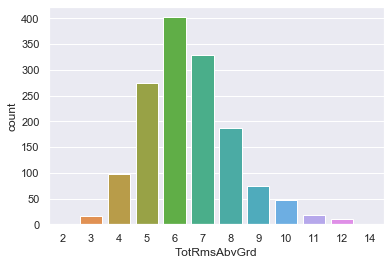

In [31]:
sns.countplot(data=training_data, x='BedroomAbvGr'); plt.show()
sns.countplot(data=training_data, x='KitchenAbvGr'); plt.show()
sns.countplot(data=training_data, x='TotRmsAbvGrd'); plt.show()

- Most houses have 3 bedrooms, 1 kitchen, 6 rooms in total

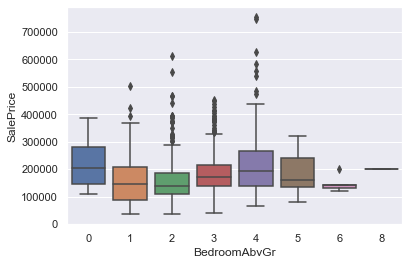

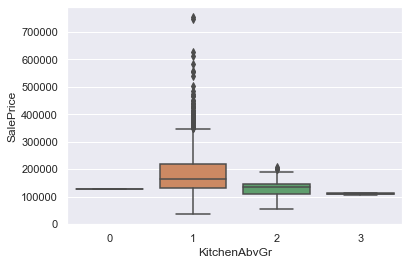

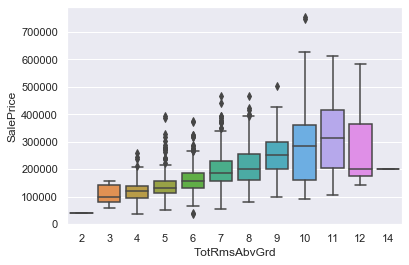

In [32]:
sns.boxplot(data=training_data, x='BedroomAbvGr', y='SalePrice'); plt.show()
sns.boxplot(data=training_data, x='KitchenAbvGr', y='SalePrice'); plt.show()
sns.boxplot(data=training_data, x='TotRmsAbvGrd', y='SalePrice'); plt.show()

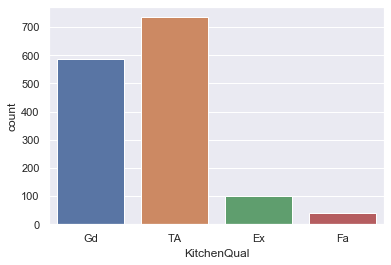

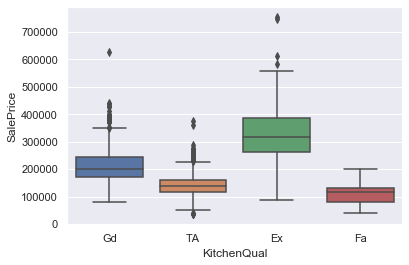

In [33]:
sns.countplot(data=training_data, x='KitchenQual'); plt.show()
sns.boxplot(data=training_data, x='KitchenQual', y='SalePrice'); plt.show()

- All of these features should  be useful.

## Basement

- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinSF1
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF

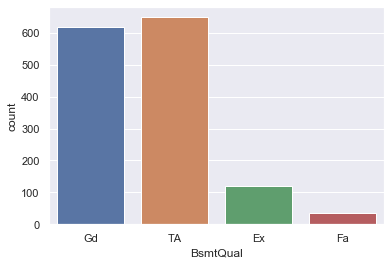

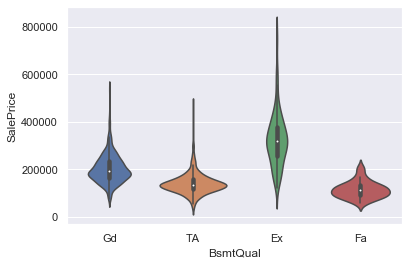

In [34]:
sns.countplot(data=training_data, x='BsmtQual'); plt.show()
sns.violinplot(data=training_data, x='BsmtQual', y='SalePrice');

In [35]:
training_data['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [36]:
training_data['BsmtQual'].isnull().sum()

37

- BsmtQual captures the basement height. Houses with higher basements are more expensive.

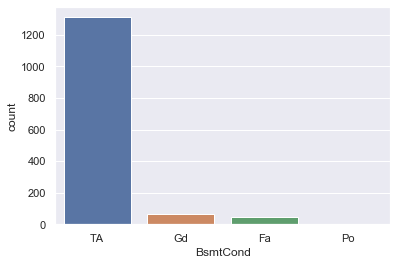

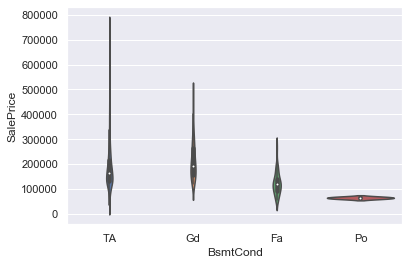

In [37]:
sns.countplot(data=training_data, x='BsmtCond'); plt.show()
sns.violinplot(data=training_data, x='BsmtCond', y='SalePrice');

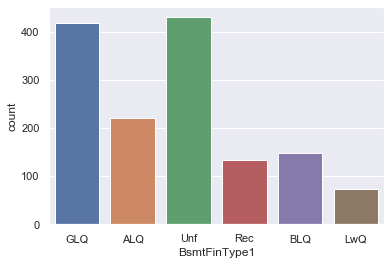

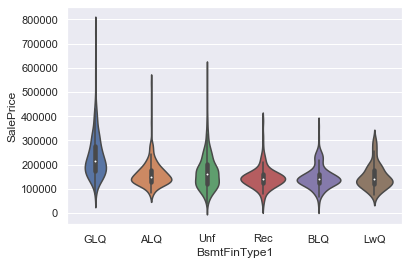

In [38]:
sns.countplot(data=training_data, x='BsmtFinType1'); plt.show()
sns.violinplot(data=training_data, x='BsmtFinType1', y='SalePrice');

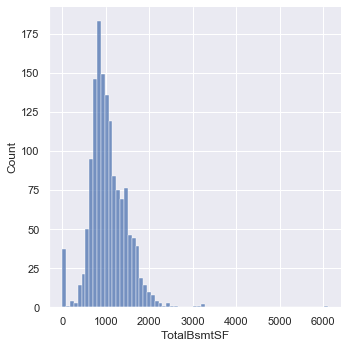

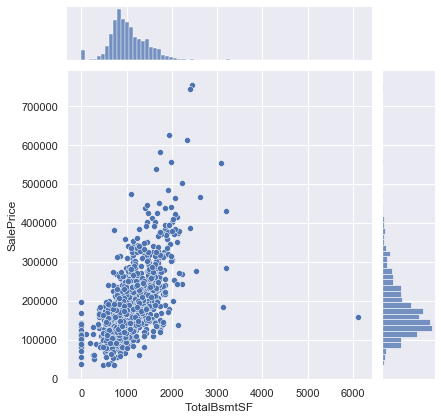

In [39]:
sns.displot(data=training_data, x='TotalBsmtSF'); plt.show()
sns.jointplot(data=training_data, x='TotalBsmtSF', y='SalePrice');

- Square footage of basement is reasonably well-correlated with sale price.

## Garage

- GarageType
- GarageYrBlt
- GarageFinish
- GarageCars
- GarageArea
- GarageQual
- GarageCond

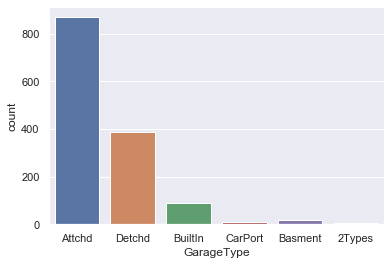

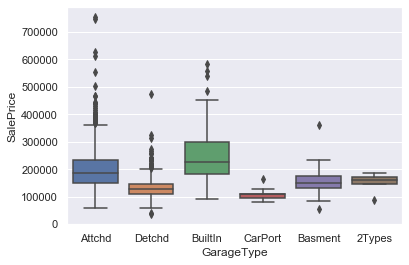

In [40]:
sns.countplot(data=training_data, x='GarageType'); plt.show()
sns.boxplot(data=training_data, x='GarageType', y='SalePrice');

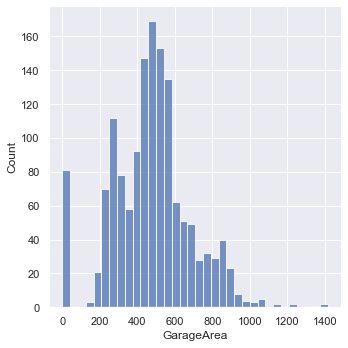

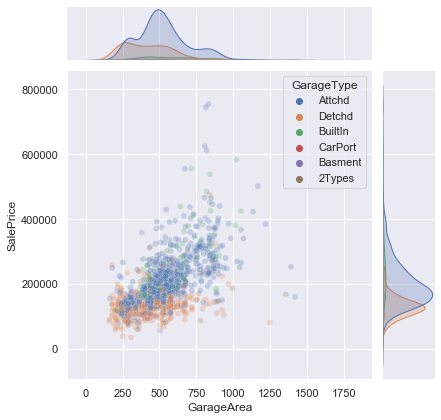

In [41]:
sns.displot(data=training_data, x='GarageArea'); plt.show()
sns.jointplot(data=training_data, x='GarageArea', y='SalePrice', hue='GarageType', alpha=0.25);

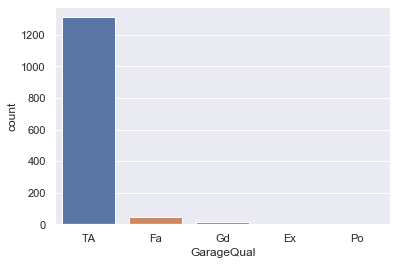

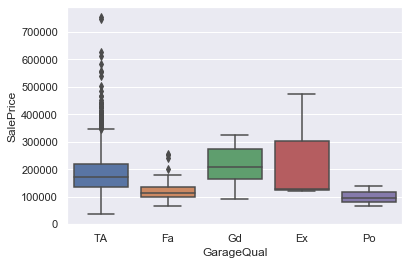

In [42]:
sns.countplot(data=training_data, x='GarageQual'); plt.show()
sns.boxplot(data=training_data, x='GarageQual', y='SalePrice');

- It looks like out of all the different garage features GarageArea and GarageType are most important.

## Exterior and Roof

- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- MasVnrArea
- ExterQual
- ExterCond

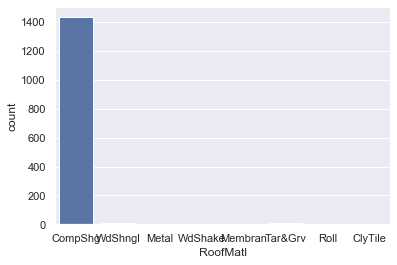

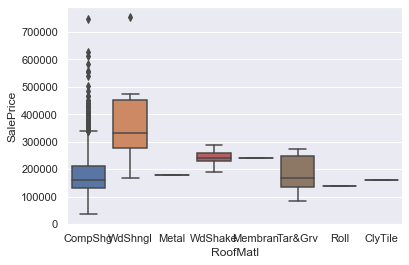

In [43]:
sns.countplot(data=training_data, x='RoofMatl'); plt.show()
sns.boxplot(data=training_data, x='RoofMatl', y='SalePrice');

- Probably best to ignore these features for now.

**Luxury features**

- Fireplaces
- FireplaceQu

**Porch/Patio/Pool**

- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- PoolQC
- Fence
- MiscFeature
- MiscVal

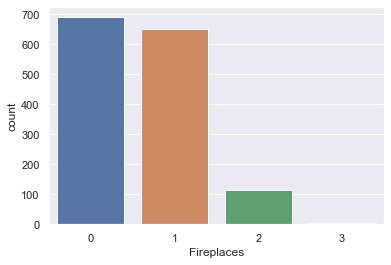

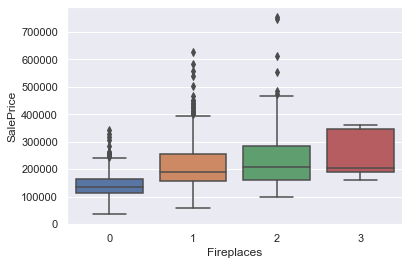

In [44]:
sns.countplot(data=training_data, x='Fireplaces'); plt.show()
sns.boxplot(data=training_data, x='Fireplaces', y='SalePrice');

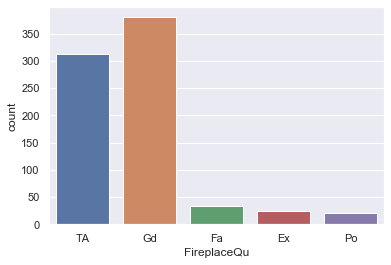

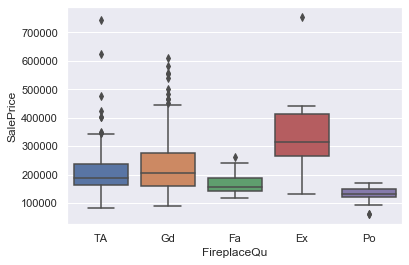

In [45]:
sns.countplot(data=training_data, x='FireplaceQu'); plt.show()
sns.boxplot(data=training_data, x='FireplaceQu', y='SalePrice');

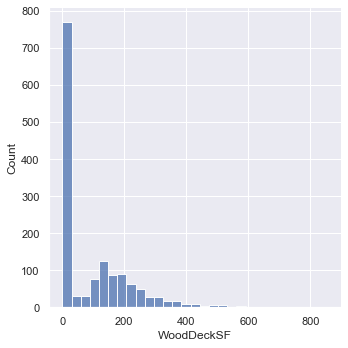

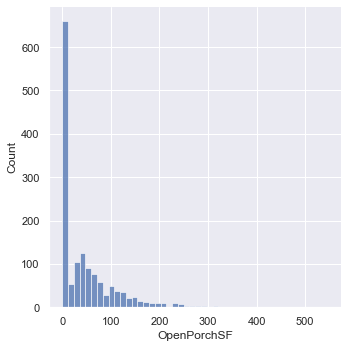

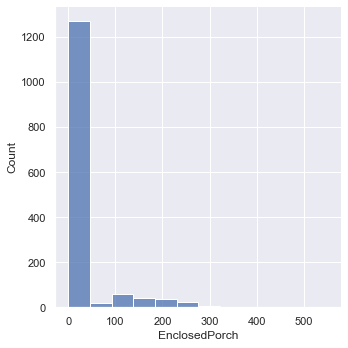

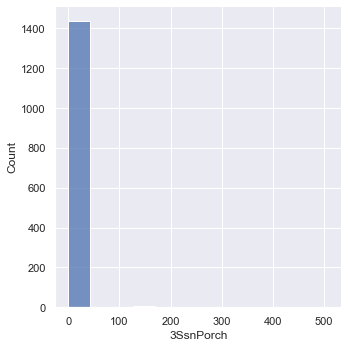

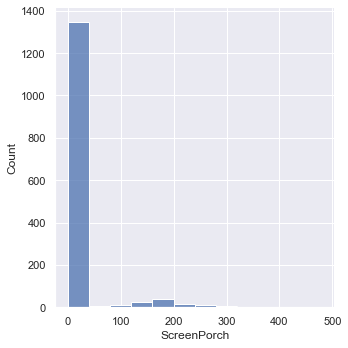

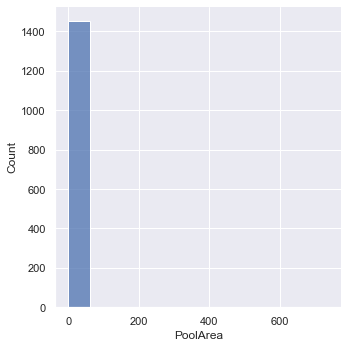

In [46]:
sns.displot(data=training_data, x='WoodDeckSF'); plt.show()
sns.displot(data=training_data, x='OpenPorchSF'); plt.show()
sns.displot(data=training_data, x='EnclosedPorch'); plt.show()
sns.displot(data=training_data, x='3SsnPorch'); plt.show()
sns.displot(data=training_data, x='ScreenPorch'); plt.show()
sns.displot(data=training_data, x='PoolArea'); plt.show()

- Lots of house without special features like porch/pool.

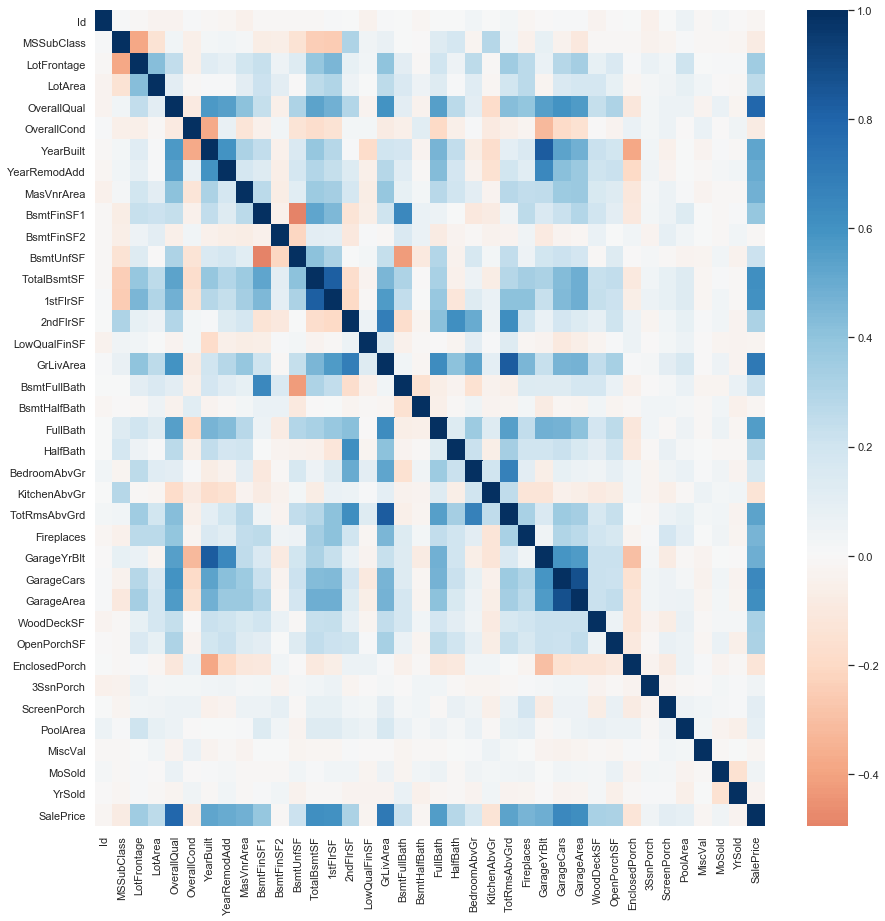

In [47]:
fig, ax = plt.subplots(figsize=[15.0,15.0])
sns.heatmap(training_data.corr(), cmap='RdBu', center=0.0);

## Feature Engineering

There are a few features that could be useful if added, although they are already represented to a large part in the existing features: total living space, age of house, age of remodelling.

Replacing the MSSubClass and Neighborhood categories by the average house prices.

In [48]:
def add_features(df):
    df['HouseAge'] = 2010 - df['YearBuilt']
    df['RemodelAge'] = 2010 - df['YearRemodAdd']
    return df

In [49]:
neighborhood_prices = training_data.groupby('Neighborhood')['SalePrice'].agg('mean')
mssubclass_prices = training_data.groupby('MSSubClass')['SalePrice'].agg('mean')

def groupby_avg(df, neighborhood_prices, mssubclass_prices):
    df['NeighborhoodAvgPrice'] = df['Neighborhood'].apply(lambda x: neighborhood_prices[x])
    #df['MSSubClassAvgPrice'] = df['MSSubClass'].apply(lambda x: mssubclass_prices[x])
    df.drop(['Neighborhood', 'MSSubClass'], axis=1, inplace=True)
    return df

## Preliminary Model Exploration with Random Forests

Based on the EDA above, let's start by using the following features for the model:

In [50]:
general_features = ['MSSubClass', 'LotArea', 'LotFrontage', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'Foundation']
rooms_features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual']
basement_features = ['TotalBsmtSF', 'BsmtFinType1']
garage_features = ['GarageType', 'GarageArea']
fireplace_features = ['Fireplaces', 'FireplaceQu']
outside_features = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
target_feature = ['SalePrice']

all_features = general_features + rooms_features + basement_features + garage_features + fireplace_features + outside_features + target_feature

In [51]:
# make a copy of the dataframe
df_train = training_data[all_features].copy()
# add simple features
df_train = add_features(df_train)
df_train = groupby_avg(df_train, neighborhood_prices, mssubclass_prices)

df_train.head()

,LotArea,LotFrontage,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Foundation,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,KitchenQual,TotalBsmtSF,BsmtFinType1,GarageType,GarageArea,Fireplaces,FireplaceQu,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice,HouseAge,RemodelAge,NeighborhoodAvgPrice
0,8450,65.0,1Fam,2Story,7,2003,2003,PConc,856,854,1710,2,1,3,1,8,Gd,856,GLQ,Attchd,548,0,NaN,0,61,0,0,0,0,208500,7,7,197965.773333
1,9600,80.0,1Fam,1Story,6,1976,1976,CBlock,1262,0,1262,2,0,3,1,6,TA,1262,ALQ,Attchd,460,1,TA,298,0,0,0,0,0,181500,34,34,238772.727273
2,11250,68.0,1Fam,2Story,7,2001,2002,PConc,920,866,1786,2,1,3,1,6,Gd,920,GLQ,Attchd,608,1,TA,0,42,0,0,0,0,223500,9,8,197965.773333
3,9550,60.0,1Fam,2Story,7,1915,1970,BrkTil,961,756,1717,1,0,3,1,7,Gd,756,ALQ,Detchd,642,1,Gd,0,35,272,0,0,0,140000,95,40,210624.725490
4,14260,84.0,1Fam,2Story,8,2000,2000,PConc,1145,1053,2198,2,1,4,1,9,Gd,1145,GLQ,Attchd,836,1,TA,192,84,0,0,0,0,250000,10,10,335295.317073


In [52]:
df_train.loc[:,df_train.dtypes != 'object'].head()

,LotArea,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,TotalBsmtSF,GarageArea,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice,HouseAge,RemodelAge,NeighborhoodAvgPrice
0,8450,65.0,7,2003,2003,856,854,1710,2,1,3,1,8,856,548,0,0,61,0,0,0,0,208500,7,7,197965.773333
1,9600,80.0,6,1976,1976,1262,0,1262,2,0,3,1,6,1262,460,1,298,0,0,0,0,0,181500,34,34,238772.727273
2,11250,68.0,7,2001,2002,920,866,1786,2,1,3,1,6,920,608,1,0,42,0,0,0,0,223500,9,8,197965.773333
3,9550,60.0,7,1915,1970,961,756,1717,1,0,3,1,7,756,642,1,0,35,272,0,0,0,140000,95,40,210624.725490
4,14260,84.0,8,2000,2000,1145,1053,2198,2,1,4,1,9,1145,836,1,192,84,0,0,0,0,250000,10,10,335295.317073


I just want to get a quick look at model performance and feature importance before building a full processing pipeline. Extracting feature importance from a multi-step sklearn pipeline is a little fiddly so I'd like to get some insight at this point.

In [53]:
# import ML models
from sklearn.ensemble import RandomForestRegressor
# import model validation functionality
from sklearn.model_selection import cross_val_score

X = df_train.loc[:,df_train.dtypes != 'object'].drop('SalePrice', axis=1).fillna(0.0)
y = df_train['SalePrice']

rf_model = RandomForestRegressor()

cross_val_score(rf_model, X, y, scoring='neg_root_mean_squared_error', cv=5)

array([-27147.0492954 , -32705.35921563, -31433.59842086, -27143.58152957,
       -32854.42659602])

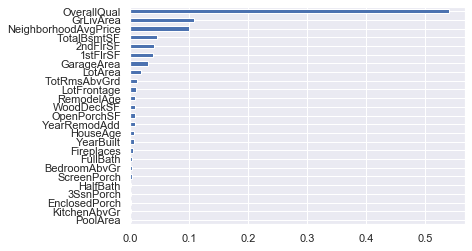

In [54]:
rf_model.fit(X, y)
rf_model.feature_importances_

feat_import = pd.Series(rf_model.feature_importances_)
feat_import.index = X.columns
feat_import.sort_values().plot(kind='barh');

It looks like OverallQual is by far the most important feature, followed by GrLivArea and NeighborhoodAvgPrice.

## Data Preprocessing

In [65]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# make a copy of the dataframe
df_train = training_data[all_features].copy()
# add simple features - this step isn't straightfoward to include in a sklearn pipeline
df_train = add_features(df_train)
df_train = groupby_avg(df_train, neighborhood_prices, mssubclass_prices)

# same for the test data
df_test = test_data[[f for f in all_features if f != 'SalePrice']].copy()
df_test = add_features(df_test)
df_test = groupby_avg(df_test, neighborhood_prices, mssubclass_prices)

# imputers for num and cat features
cat_imp = SimpleImputer(strategy='constant', fill_value='None')
num_imp = SimpleImputer(strategy='constant', fill_value=0.0)

# onehot encoding for cat features
OH_enc = OneHotEncoder(drop=None, sparse=False, handle_unknown='ignore')

cat_transformer = Pipeline(steps=[('cat_imp', cat_imp), ('onehot', OH_enc)])
cat_features = df_train.columns[df_train.dtypes == 'object']
num_features = [f for f in df_train.columns[df_train.dtypes != 'object'] if f !='SalePrice']

# full preprocessor
preproc = ColumnTransformer(transformers=[('cat', cat_transformer, cat_features), ('num', num_imp, num_features)])

## Models

In [70]:
# import ML models
from sklearn.ensemble import RandomForestRegressor
# import model validation functionality
from sklearn.model_selection import cross_val_score, GridSearchCV

y_train = df_train['SalePrice']
X_train = df_train.drop(['SalePrice'], axis=1)

X_test = df_test

rf_model = Pipeline(steps=[('preproc', preproc), ('model', RandomForestRegressor())])
print(np.mean(cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error')))

param_grid = {'model__n_estimators':[100],
             #'model__criterion':['mae', 'mse'],
             'model__min_samples_split':[2,3,4],
             'model__min_samples_leaf' :[1,2,3],
             'model__max_features':['sqrt']}

gsearch = GridSearchCV(rf_model, param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gsearch.fit(X_train, y_train)

best_model = gsearch.best_estimator_
parameters = gsearch.best_params_
print(parameters)
print('Best score:', gsearch.best_score_)

-29747.05977031535
{'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 100}
Best score: -28396.091394556057


In [76]:
y_pred = best_model.predict(X_test)

In [77]:
submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':y_pred})

In [85]:
submission[['Id', 'SalePrice']].to_csv('submission.csv')

In [86]:
submission.to_csv('submission.csv', index=False)

In [80]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [81]:
submission.values

array([[  1461.        , 127805.59969048],
       [  1462.        , 148620.72738095],
       [  1463.        , 181243.18297619],
       ...,
       [  2917.        , 159462.535     ],
       [  2918.        , 124538.54291667],
       [  2919.        , 225703.183     ]])

In [83]:
sample.values

array([[  1461.        , 169277.0524984 ],
       [  1462.        , 187758.39398877],
       [  1463.        , 183583.68356955],
       ...,
       [  2917.        , 219222.42340006],
       [  2918.        , 184924.279659  ],
       [  2919.        , 187741.86665748]])